In [ ]:
#connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'MyDrive/'gan_mnist

Mounted at /content/drive
/content/drive/MyDrive/gan_mnist


In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

torch.manual_seed(123)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
imgsize = 28
BATCH_SIZE = 128
DATA_DIR = '/content/drive/MyDrive/gan_mnist/'
IMG_DIR = os.path.join(DATA_DIR, 'results')

In [ ]:
#useful functions

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), savepath=None):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    if savepath is not None:
      plt.savefig(savepath)
      
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def image2vec(imgs, img_dim):
  return imgs.view(imgs.size(0), img_dim*img_dim)

def vec2image(vecs, img_dim):
  return vecs.view(vecs.size(0), img_dim, img_dim)

def noise(size, dim, device):
  return torch.randn(size, dim).to(device)

def real_data_target(size, device):
  return torch.ones(size, 1).to(device)

def fake_data_target(size, device):
  return torch.zeros(size, 1).to(device)

def log_images(test_images, savepath=None):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  rows, cols = len(test_images)//4, 4

  for i, img in enumerate(test_images):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
  
  if savepath is not None:
    figure.savefig(savepath)
  
  plt.show()

In [ ]:
#download dataset
data_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5))])

mnist_data = MNIST(DATA_DIR,
                   transform=data_transform,
                   download=True)

dataloader = DataLoader(mnist_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [ ]:
#generator model
class Generator(nn.Module):
  def __init__(self, in_dim, out_dim):
      super().__init__()

      self.layers = nn.Sequential(
          nn.Linear(in_dim, 256),
          nn.LeakyReLU(0.2),
          nn.Linear(256, 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512, 1024),
          nn.LeakyReLU(0.2),
          nn.Linear(1024, out_dim),
          nn.Tanh(),
      )
  
  def forward(self, z):
    return self.layers(z)


In [ ]:
#discriminator model
class Discriminator(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_dim, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, out_dim),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.layers(x)

In [ ]:
noise_dim = 100

generator = Generator(noise_dim, imgsize*imgsize).to(device)
discriminator = Discriminator(imgsize*imgsize, 1).to(device)

In [ ]:
#optimizers
lr = 2e-4

g_opt = optim.Adam(generator.parameters(), lr=lr)
d_opt = optim.Adam(discriminator.parameters(), lr=lr)

#loss function
loss = nn.BCELoss()

In [ ]:
#training functions

def train_discriminator(discriminator, loss, optimizer, real_data, fake_data):
  #erase previous grads
  optimizer.zero_grad()

  #discriminator prediction using real data
  pred_real = discriminator(real_data)
  #error w.r.t real data
  error_real = loss(pred_real, torch.ones_like(pred_real))

  #discriminator prediction using fake data
  pred_fake = discriminator(fake_data.detach())
  #error w.r.t fake data
  error_fake = loss(pred_fake, torch.zeros_like(pred_fake))

  #total error
  error = (error_real + error_fake)/2

  #backpropagation
  error.backward()

  #next step
  optimizer.step()

  return error, pred_real, pred_fake


def train_generator(discriminator, loss, optimizer, fake_data):
  #erase previous grad
  optimizer.zero_grad()

  #discriminator prediction using generator data
  pred = discriminator(fake_data)
  #error w.r.t. fake data
  error = loss(pred,
               real_data_target(pred.size(0),
                                device))
  #backpropagation
  error.backward()

  #next step
  optimizer.step()

  return error, pred

In [ ]:
#training

EPOCHS = 200
G_losses = []
D_losses = []

test_noise = noise(16, noise_dim, device=device)

for epoch in range(EPOCHS):
  for real_batch, _ in dataloader:

    #convert images to vectors and put them in GPU 
    real_data = image2vec(real_batch, imgsize).to(device)
    
    #generate fake data for discriminator training
    fake_noise = noise(real_data.size(0), noise_dim, device=device)
    fake_data = generator(fake_noise)
    
    #train discriminator
    d_error, dpred_real, dpred_fake = (train_discriminator(discriminator, loss, d_opt, real_data, fake_data))

    #generate fake data for generator training
    gfake_noise = noise(real_batch.size(0), noise_dim, device=device)
    gfake_data = generator(gfake_noise)
    
    #train generator
    g_error, gpred = (train_generator(discriminator, loss, g_opt, gfake_data))

  #show generated images
  imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
  test_images = vec2image(generator(test_noise), imgsize).cpu().detach()
  log_images(test_images, imagepath)

  #Display status logs
  G_losses.append(g_error)
  D_losses.append(d_error)
  print(f"Epoch: {epoch}/{EPOCHS} Losses:")
  print(f"Discriminator: {d_error:.4f}; Generator: {g_error:.4f}")
  print(f"D(x): {dpred_real.mean():.4f}; D(G(z)): {dpred_fake.mean():.4f}")

Output hidden; open in https://colab.research.google.com to view.

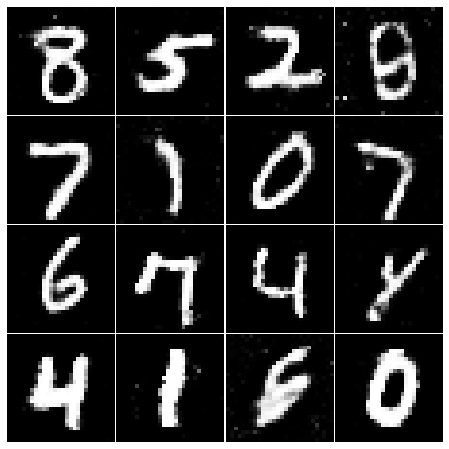

In [ ]:
test_images = vec2image(generator(noise(16, noise_dim, device)), imgsize).cpu().detach()
log_images(test_images)

In [ ]:
GEN_DIR = os.path.join(DATA_DIR, 'generator')
DIS_DIR = os.path.join(DATA_DIR, 'discriminator')

torch.save(generator, GEN_DIR)
torch.save(discriminator, DIS_DIR)

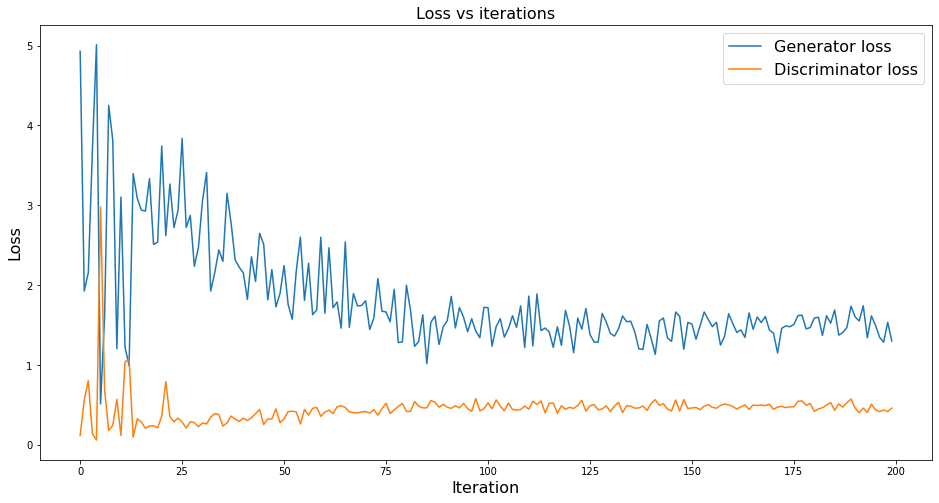

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(16, 8))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    loss_values = [k.item() for k in loss_values]  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

plot_losses({"Generator loss": G_losses, 
             "Discriminator loss": D_losses})

In [16]:
import imageio

images = []
for filename in sorted(os.listdir(IMG_DIR), key = lambda x: float(x.split('.')[0])):
    if filename.endswith('.jpg'):
        filepath = os.path.join(IMG_DIR, filename)
        images.append(imageio.imread(filepath))
imageio.mimsave('fashion_training.gif', images)